In [1]:
#import package
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from torch.utils.data import DataLoader
import os
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [2]:
## Create transform wait out normalize
manual_transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor()
    ])

In [3]:
## Downloading data
BATCH_SIZE=32
NUM_WORKER=os.cpu_count()
train_set = torchvision.datasets.CIFAR10(root = 'data',train=True,download=True,transform=manual_transform)
test_set = torchvision.datasets.CIFAR10(root = 'data',train=False,download=True,transform=manual_transform)


100%|██████████| 170M/170M [00:04<00:00, 39.0MB/s]


In [4]:
%%writefile find_normalize_number.py
import torchvision
import torch
import os
def find_normalize_number(trainset:torchvision.datasets,
                          num_workers:int = os.cpu_count()):
    loader = torch.utils.data.DataLoader(trainset, batch_size=200, shuffle=False, num_workers=2)

    mean = 0.
    std = 0.
    nb_samples = 0.

    for data, _ in loader:
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)  # flatten H*W
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
        nb_samples += batch_samples

    mean /= nb_samples
    std /= nb_samples
    return mean,std

Writing find_normalize_number.py


In [5]:
import find_normalize_number
mean,std=find_normalize_number.find_normalize_number(train_set)

In [6]:
mean,std

(tensor([0.4914, 0.4822, 0.4465]), tensor([0.2023, 0.1994, 0.2010]))

In [7]:
## Create transform wait normalize number
manual_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),transforms.Normalize(mean,std)
    ])

In [8]:
## Downloading data
BATCH_SIZE=32
NUM_WORKER=os.cpu_count()
train_set = torchvision.datasets.CIFAR10(root = 'data',train=True,download=False,transform=manual_transform)
test_set = torchvision.datasets.CIFAR10(root = 'data',train=False,download=False,transform=manual_transform)


In [9]:
train_dataloader = DataLoader(dataset=train_set,batch_size=BATCH_SIZE,shuffle=True,num_workers=NUM_WORKER)
test_dataloader = DataLoader(dataset=test_set,batch_size=BATCH_SIZE,shuffle=False,num_workers=NUM_WORKER)
class_names = train_dataloader.dataset.classes

In [10]:
train_dataloader.dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=tensor([0.4914, 0.4822, 0.4465]), std=tensor([0.2023, 0.1994, 0.2010]))
           )

In [11]:
images , label = next(iter(train_dataloader))

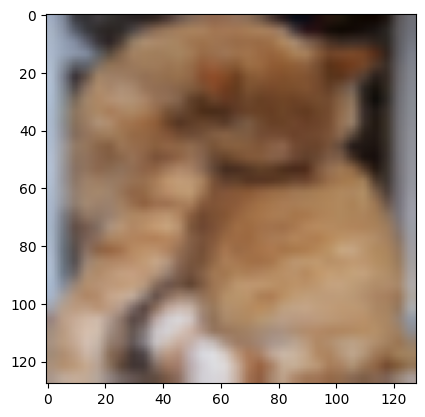

'cat'

In [12]:
#plot some image
img = images[5]
img = img * std[:, None, None] + mean[:, None, None]  # reverse normalization
plt.imshow(img.permute(1, 2, 0))
plt.show()
class_names[label[5]]

In [13]:
# Ok lets create our CNN model to train

In [14]:
from torch import nn
class CIFAR10Model(nn.Module):
    def __init__(self,hidden_unit,input_shape,output_shape):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,out_channels=hidden_unit,kernel_size=3,stride=1,padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_unit,out_channels=hidden_unit,kernel_size=3,stride=1,padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)#default stride size is same as kernelsize
        )
        self.conv_block_2=nn.Sequential(
            nn.Conv2d(in_channels=hidden_unit,out_channels=hidden_unit,kernel_size=3,stride=1,padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_unit,out_channels=hidden_unit,kernel_size=3,stride=1,padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)#default stride size is same as kernelsize
        )
        self.classifier=nn.Sequential(
            nn.Flatten(),
            nn.Dropout(),
            nn.Linear(in_features=8410,
                      out_features=output_shape)
        )
    def forward(self,x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        #print(f'shape is {x.shape}')
        x = self.classifier(x)
        return x
model = CIFAR10Model(hidden_unit=10,input_shape=3,output_shape=len(class_names)).to(device)


In [15]:
model(images.to(device))

tensor([[ 1.2516e-04,  6.4561e-02,  4.6328e-02,  4.3166e-02, -4.3294e-02,
          8.5644e-03, -2.3814e-02, -2.3568e-02, -6.1246e-02, -3.3999e-02],
        [ 1.6351e-02,  5.6923e-02,  9.8147e-02, -1.0371e-02, -5.4991e-03,
          6.2273e-02, -3.2228e-02, -8.0890e-02,  9.5507e-03, -2.0452e-02],
        [ 6.2582e-02,  8.0038e-02,  4.0635e-02,  2.5319e-02, -1.2058e-01,
          3.7346e-02,  3.2537e-02, -1.0910e-01,  2.3638e-02, -1.8306e-01],
        [ 8.7390e-02,  2.9353e-02,  1.0865e-01, -3.7223e-02, -6.0252e-02,
          2.7970e-02,  3.3208e-02, -4.9387e-02, -1.6521e-02, -8.3627e-02],
        [ 3.6443e-03,  6.9505e-02,  4.5836e-02,  2.7007e-02,  2.1438e-02,
          6.8045e-02, -1.7966e-02, -7.3777e-02, -4.4950e-02, -4.8463e-02],
        [ 9.6604e-03,  9.9808e-02, -3.9374e-04,  1.3597e-02, -5.2203e-02,
         -7.7763e-02, -4.6502e-02, -8.8938e-02,  9.3334e-03,  3.8685e-02],
        [ 3.4722e-02,  4.1338e-02,  1.7077e-02,  4.4921e-02,  3.5929e-02,
          1.3638e-02,  1.0382e-0

In [16]:
##lets train our CIFAR10Model

In [17]:
optimizer = torch.optim.SGD(lr=0.01,params=model.parameters())
loss_fn = nn.CrossEntropyLoss()

In [18]:
def train_step(model:nn.Module,
          optimizer:torch.optim,
          loss_fn:nn.Module,
          dataloader:DataLoader,
          accuracy_fn,
          device:torch.device):
    model.train()
    train_acc,train_loss = 0,0
    for batch,(X,y) in enumerate(dataloader): ##--> Batch 0 || X shape: torch.Size([32, 3, 224, 224])  || y shape: torch.Size([32])
        #print(f'batch_num:{batch}')
        X,y = X.to(device) , y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred,y)
        train_acc+=accuracy_fn(y,y_pred.argmax(dim=1))
        train_loss+=loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_acc/=len(dataloader)
    train_loss/=len(dataloader)
    return train_loss,train_acc

In [19]:
def test_step(model:nn.Module,
             dataloader:DataLoader,
             loss_fn:nn.Module,
             accuracy_fn,
          device:torch.device):
    test_acc , test_loss = 0,0
    model.eval()
    with torch.inference_mode():
        for batch,(X,y) in enumerate(dataloader):
            X,y = X.to(device),y.to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred,y)
            test_acc += accuracy_fn(y,y_pred.argmax(dim=1))
            test_loss += loss.item()

        test_loss/=len(dataloader)
        test_acc/=len(dataloader)
        return test_loss,test_acc

In [20]:
from tqdm.auto import tqdm
from timeit import default_timer as timer
def train(model:nn.Module,
         train_dataloader:DataLoader,
         test_dataloader:DataLoader,
         epochs:int,
         optimizer:torch.optim,
         loss_fn:nn.Module,
         accuracy_fn,
         device:torch.device):

    results={
        "train_loss":[],
        "train_acc":[],
        "test_loss":[],
        "test_acc":[]
    }
    start = timer()
    for epoch in tqdm(range(epochs)):
        train_loss,train_acc = train_step(model,optimizer,loss_fn,train_dataloader,accuracy_fn,device)
        test_loss,test_acc = test_step(model,test_dataloader,loss_fn,accuracy_fn,device)
        print(f"Epochs :{epoch} | Train loss :{train_loss:.4} | Train accuracy :{train_acc:.3} | Test loss :{test_loss:.4} | Test accuracy :{test_acc:.3} " )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    end = timer()
    print(f'Training & testing operation take {end-start} seconds!!')
    return results



In [21]:
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between target (y_true) and predictions (y_pred)."""
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [22]:
results = train(model,train_dataloader,test_dataloader,5,optimizer,loss_fn,accuracy_fn,device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epochs :0 | Train loss :1.859 | Train accuracy :33.6 | Test loss :1.766 | Test accuracy :37.0 
Epochs :1 | Train loss :1.603 | Train accuracy :42.9 | Test loss :1.874 | Test accuracy :41.0 
Epochs :2 | Train loss :1.474 | Train accuracy :47.2 | Test loss :1.469 | Test accuracy :48.4 
Epochs :3 | Train loss :1.407 | Train accuracy :49.4 | Test loss :1.409 | Test accuracy :50.0 
Epochs :4 | Train loss :1.346 | Train accuracy :51.8 | Test loss :1.473 | Test accuracy :50.1 
Training & testing operation take 274.475243537 seconds!!


In [23]:
#let's predict on my custome image
import requests
from pathlib import Path
data_path=Path('image_data/')
if data_path.is_dir():
  print('your picture is already exist')
else:

  source="https://hips.hearstapps.com/hmg-prod/amv-prod-cad-assets/images/09q4/300860/2012-lexus-lfa-review-car-and-driver-photo-302743-s-original.jpg"
  target_file = Path(source).name
  data_path.mkdir(parents=True, exist_ok=True)
  with open(data_path / target_file , "wb") as f:
        request = requests.get(source)
        print(f"Downloading {target_file} from {source}")
        f.write(request.content)

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

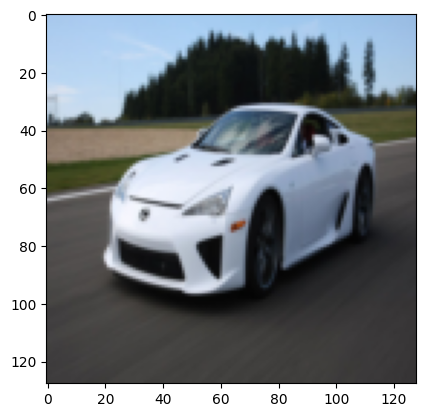

In [24]:
from PIL import Image

img_path = Path("image_data/").glob('*.jpg')
img_path = list(img_path)[0]


img = Image.open(img_path).convert('RGB') # Convert to RGB to ensure 3 channels

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((128,128)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean,std)
])

img_transformed = transform(img)
img_show = img_transformed *std[:,None,None] + mean[:,None,None]
plt.imshow(img_show.permute(1,2,0))

model.eval()
with torch.inference_mode():
    pred_logits = model(img_transformed)
    pred_num = pred_logits.argmax(dim=1).item()


print(f'Our prediction is {class_names[pred_num]} wait this chance {pred_logits[pred_logits.argmax(dim=1)]}')
